# 0. Introduction

Google Trends gives a whollistic view on how a keyword is performing over time. Google does not provide exact traffic values and as such, the keyword traffic measured here is more akin to 'relative popularity'. For a more detailed explanation: https://newsinitiative.withgoogle.com/resources/trainings/google-trends-understanding-the-data/

## 0.1 Starting Hypothesis of the analysis 

Positive spikes in a company's branded keyword traffic (e.g 'salomon' for Amer Sports Inc.) is indicative of a positive earnings surprise.

## 0.2 Results (TLDR)

Fisical quarters that contain high 'relative popularity' keyword spikes with a high baseline shift (refer to 4.1 for explanation) have less negative earnings surprises (ΔP(EPS < 0) = -0.0245) and more positive earnings surprises (ΔP(EPS > 0) = 0.0361).  

## 0.3 Notes

The notebook uses some already preprocessed data from other projects. Keyword scraping took 2 weeks using Oxylabs and keyword generation requires an LLM API key and thus wouldn't make sense to include in this notebook.

Datasets of note:

1. earnings_data.csv | contains quarterly reporting of listed customer discretionary stocks. Source: EODHD

2. timeseries_branded_* | used in stl_decomposition.py | Scraped results of Google Trends values for different keywords. Source: Oxylabs
        
        - Keywords were generated with gemini-2.5-flash using company context 

Disclaimer: 
Goal of the project is to show my interest in data-analysis/feature-engineering. Some of the code (e.g plot functions and CPU paralellization) is AI-generated and not made to be as efficient as possible.

## 0.4 Future Improvements

1. Normalize keyword data. Oxylabs doesn't support keyword comparison, so all keywords are treated as equal which is not optimal for the project.
2. Parameter estimation for event windows and keyword features to find optimal patterns in keyword data.
3. Improve event window detection, so that the event doesn't start only with a residual threshold. An additional filter is required.
4. Add a minimum count filter to assigning an event to a quarter (e.g 4 keywords out of 10 have to show a spike). Right now, if a company is assigned to 30 keywords and one has an event, the quarter is classified as a quarter with an event.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ks_2samp
from stl_decomposition import run_full_pipeline, stl_decomposition, detect_events
from multiprocessing import cpu_count
from statsmodels.tsa.seasonal import STL

### Convert to Log function and plotting functions for the cumulative distribution function difference 

Features the Kolmogorov-Smirnov test to test the continuous variable (EPS surprise) distributions and to decide if the conditional distributions reject the null hypothesis

In [2]:
# Helper functions

def signed_log1p(x):
    """sign(x) * log(1 + |x|). Makes histograms readable."""
    return np.sign(x) * np.log1p(np.abs(x))


def plot_cdf_diff(y_keyword, y_all, ax, title="F_keyword(x) − F_all(x)"):
    """Plot empirical CDF difference on signed-log x scale. y_keyword, y_all: 1d arrays."""
    # Filter outliers
    y_keyword = y_keyword[(y_keyword >= -OUTLIER_THRESHOLD) & (y_keyword <= OUTLIER_THRESHOLD)]
    
    x_grid = np.unique(np.percentile(np.hstack((y_keyword, y_all)), np.linspace(0, 100, 301)))
    if len(x_grid) < 2:
        return
    F_kw = np.mean(y_keyword.values[:, None] <= x_grid, axis=0) if hasattr(y_keyword, 'values') else np.mean(np.asarray(y_keyword)[:, None] <= x_grid, axis=0)
    F_al = np.mean(y_all.values[:, None] <= x_grid, axis=0) if hasattr(y_all, 'values') else np.mean(np.asarray(y_all)[:, None] <= x_grid, axis=0)
    ax.plot(signed_log1p(x_grid), F_kw - F_al, color="C0")
    ax.axhline(0, color="gray", linestyle="--", alpha=0.8)
    ax.set_xlabel("EPS surprise (%) — signed log scale")
    ax.set_ylabel("F_keyword(x) − F_all(x)")
    ax.set_title(title)
    tick_vals = np.array([-100, -10, -1, 0, 1, 10, 100, 1000, 1e4])
    ax.set_xticks(signed_log1p(tick_vals))
    ax.set_xticklabels([f"{t:.0f}" if abs(t) >= 1 else f"{t:.1f}" for t in tick_vals])

def plot_feature_hist_and_cdf_diff(df, feature_col, threshold, y_all, ax_hist=None, ax_cdf=None, ax_cdf_signed=None, title_prefix=None):
    """Plot histogram of EPS surprise and F_keyword−F_all for rows with feature_col > threshold. One per (company, quarter). Returns (mean_y, var_y, n)."""
    if title_prefix is None:
        title_prefix = feature_col
    df = df.copy()
    if feature_col in df.columns:
        df[feature_col] = pd.to_numeric(df[feature_col], errors="coerce")
    mask = df[feature_col] > threshold
    sub = df.loc[mask].drop_duplicates(subset=["company", "quarter_end"])
    y = sub["surprisePercent"]
    
    # Filter outliers
    y = y[(y >= -OUTLIER_THRESHOLD) & (y <= OUTLIER_THRESHOLD)]
    n = len(y)
    if n == 0:
        if ax_hist is None:
            fig, ax_hist = plt.subplots(figsize=(8, 3))
            ax_hist.text(0.5, 0.5, f"No data for {feature_col} > {threshold}", ha="center", va="center", transform=ax_hist.transAxes)
            plt.tight_layout()
            plt.show()
        return np.nan, np.nan, 0
    mean_y = float(y.mean())
    var_y = float(y.var())
    y_log = signed_log1p(y)
    tick_vals = np.array([-100, -10, -1, 0, 1, 10, 100, 1000, 1e4])
    tick_pos = signed_log1p(tick_vals)
    tick_lbl = [f"{t:.0f}" if abs(t) >= 1 else f"{t:.1f}" for t in tick_vals]
    own_fig = ax_hist is None
    if own_fig:
        if ax_cdf_signed is None:
            fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=False)
            ax_hist, ax_cdf, ax_cdf_signed = axes[0], axes[1], axes[2]
        else:
            fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=False)
            ax_hist, ax_cdf = axes[0], axes[1]
    ax_hist.hist(y_log, bins=30, edgecolor="black", alpha=0.7)
    ax_hist.axvline(0, color="gray", linestyle="--", alpha=0.8)
    ax_hist.axvline(signed_log1p(mean_y), color="red", linewidth=2, label=f"E[X] = {mean_y:.2f}%")
    ax_hist.set_xlabel("EPS surprise (%) — signed log scale")
    ax_hist.set_ylabel("Count")
    ax_hist.set_title(f"{title_prefix} > {threshold}, n = {n} quarters")
    ax_hist.set_xticks(tick_pos)
    ax_hist.set_xticklabels(tick_lbl)
    ax_hist.legend()
    plot_cdf_diff(y, y_all, ax_cdf, f"{title_prefix} > {threshold}: F − F_all")
    
    # Compute P(EPS>0) and ΔP(EPS>0)
    p_eps_positive_cond = float((y > 0).mean())
    delta_p_eps_positive = p_eps_positive_cond - p_eps_positive_all
    
    # Kolmogorov-Smirnov test vs earnings_all (y_all) at 5% level
    ks_stat, ks_pvalue = ks_2samp(np.asarray(y), np.asarray(y_all))
    alpha = 0.05
    ks_reject = ks_pvalue < alpha
    print(f"{title_prefix} > {threshold}:   E[X] = {mean_y:.4f}%   Var(X) = {var_y:.4f}   P(EPS>0) = {p_eps_positive_cond:.4f}   ΔP(EPS>0) = {delta_p_eps_positive:.4f}")
    print(f"  KS test vs earnings_all: statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}; at α={alpha}: {'Reject H0 (distributions differ)' if ks_reject else 'Fail to reject H0 (no evidence distributions differ)'}")
    
    if own_fig:
        plt.tight_layout()
        plt.show()
    return mean_y, var_y, n
    

# 1. Preparation

## 1.1 Preprocessing

1. Discludes surprisePercent outlier values, as high percentages come from EPS beats when earnings is almost equal to revenue and thus when EPS is close to zero (e.g 0.0000003 -> 0.03) .
2. First 2 years of quarters discluded, as the residual component of the keyword timeseries is not accurate. The seasonal component is generally not formed within the 2 years and as such should be discluded for more accurate modeling. 

In [3]:
# Load all-quarters for CDF comparison F_keyword(x) - F_all(x)
data_path = Path(".") / "data" / "earnings_data.csv"
earnings = pd.read_csv(data_path)
earnings["surprisePercent"] = pd.to_numeric(earnings["surprisePercent"], errors="coerce")
earnings = earnings.dropna(subset=["surprisePercent"])

# Remove outliers: filter values outside [-5000%, 5000%]
OUTLIER_THRESHOLD = 500
earnings = earnings[(earnings["surprisePercent"] >= -OUTLIER_THRESHOLD) & 
                     (earnings["surprisePercent"] <= OUTLIER_THRESHOLD)]

# Exclude first 1 years of quarters (e.g. data from 2011 -> use from 2012 onward)
earnings["date"] = pd.to_datetime(earnings["date"], utc=True)
min_date = earnings["date"].min()
cutoff = min_date + pd.DateOffset(years=1)
earnings = earnings.loc[earnings["date"] >= cutoff].copy()

y_all = earnings["surprisePercent"]
print(f"All-quarters (earnings_data): {len(y_all)} rows (after removing outliers > ±{OUTLIER_THRESHOLD}%, from {cutoff.date()} onward)")

All-quarters (earnings_data): 13766 rows (after removing outliers > ±500%, from 2011-01-31 onward)


## 1.2 The distribution of EPS surprises for all quarters

Used as the reference distribution in the Kolmogorov-Smirnov test and the CDF difference plot.

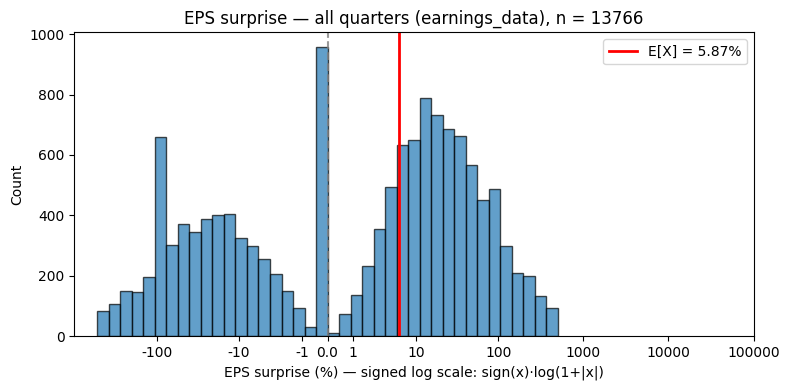

All quarters (earnings_data):  E[X] = 5.8714%   Var(X) = 8006.1260   P(EPS>0) = 0.5732


In [4]:
# Distribution of EPS surprise for ALL quarters (earnings_data), not just quarter_events
# One row per (company, quarter): use companyName and date (quarter end)
# Outliers already filtered above
y_all_log = signed_log1p(y_all)
n_all = len(y_all)
mean_all = float(y_all.mean())
var_all = float(y_all.var())
# Compute P(EPS>0) for baseline
p_eps_positive_all = float((y_all > 0).mean())

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(y_all_log, bins=40, edgecolor="black", alpha=0.7)
ax.axvline(0, color="gray", linestyle="--", alpha=0.8)
ax.axvline(signed_log1p(mean_all), color="red", linewidth=2, label=f"E[X] = {mean_all:.2f}%")
ax.set_xlabel("EPS surprise (%) — signed log scale: sign(x)·log(1+|x|)")
ax.set_ylabel("Count")
ax.set_title(f"EPS surprise — all quarters (earnings_data), n = {n_all}")
ax.legend()
tick_vals = np.array([-100, -10, -1, 0, 1, 10, 100, 1000, 1e4, 1e5])
ax.set_xticks(signed_log1p(tick_vals))
ax.set_xticklabels([f"{t:.0f}" if abs(t) >= 1 else f"{t:.1f}" for t in tick_vals])
plt.tight_layout()
plt.show()
print(f"All quarters (earnings_data):  E[X] = {mean_all:.4f}%   Var(X) = {var_all:.4f}   P(EPS>0) = {p_eps_positive_all:.4f}")

## 1.3 Analysis of the distribution of EPS surprises for all quarters

1. Estimates are quite accurate as the mode of the histogram is near 0, which means analysts are pretty good at estimating EPS. 
2. The mean of the EPS surprise is shifted to the right (P(EPS>0) = 0.572), which means analysts are more likely to underestimate earnings.

# 2. Keyword Processing

The run_full_pipeline function below does the following:

1. Extracts the residuals of the keyword timeseries by separating the seasonal and trend component, normalizes it and adjusts it based on calendar. More information here: https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

2. Detects event windows with hysteresis to calculate area_z_e and other features. The "event" here is a window of time when the Google Trends data is abnormally high.

3. Assigns keywords to its respective company/companies to form an event table. The table contains the event with its respective company quarter (the fisical quarter the event is within). 



## 2.1 Event window w/ hystersis

Demonstration of how STL decomposition works on a sample keyword time-series. The STL() function extracts the seasonal, trend and residual component of the time-series.

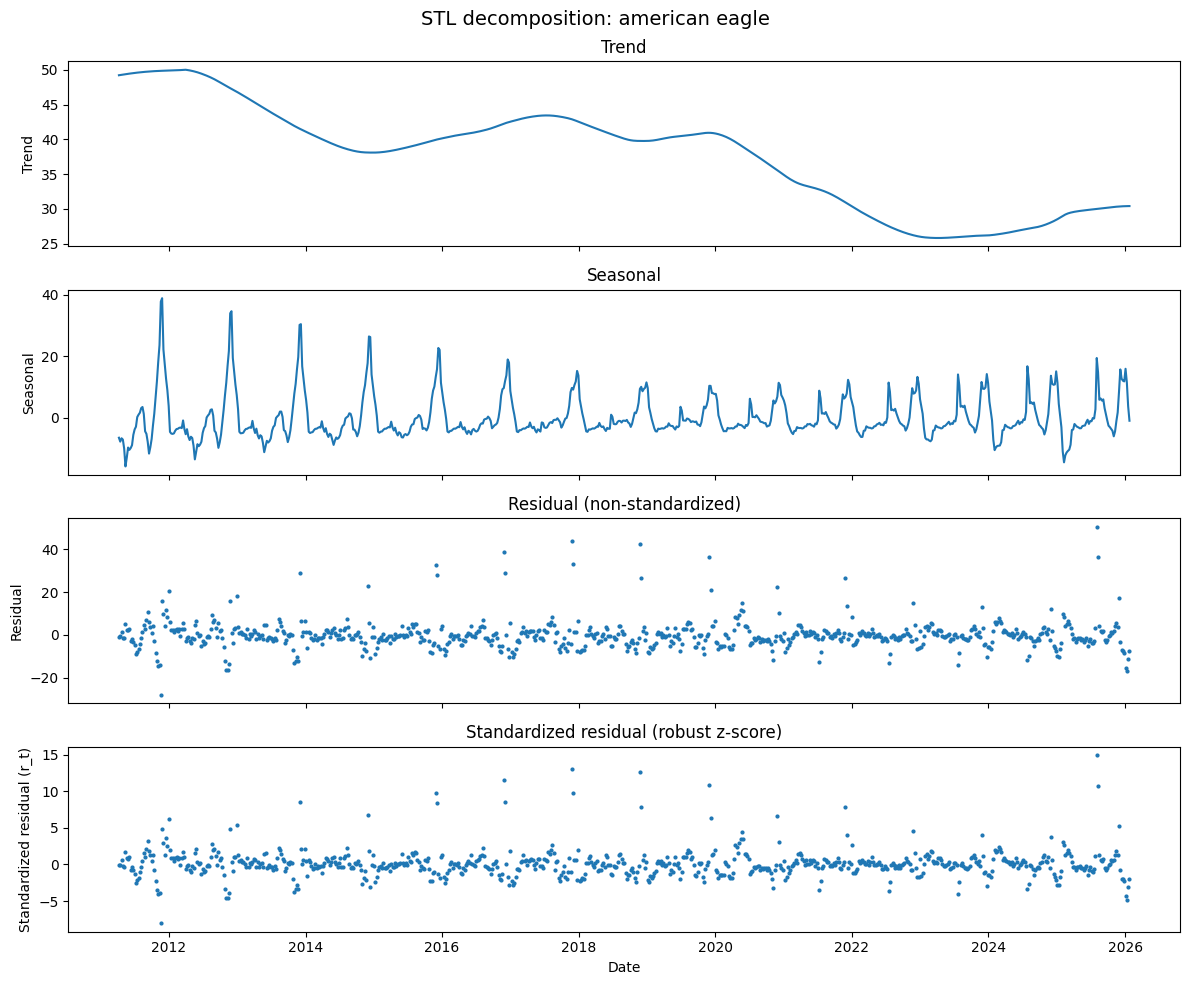

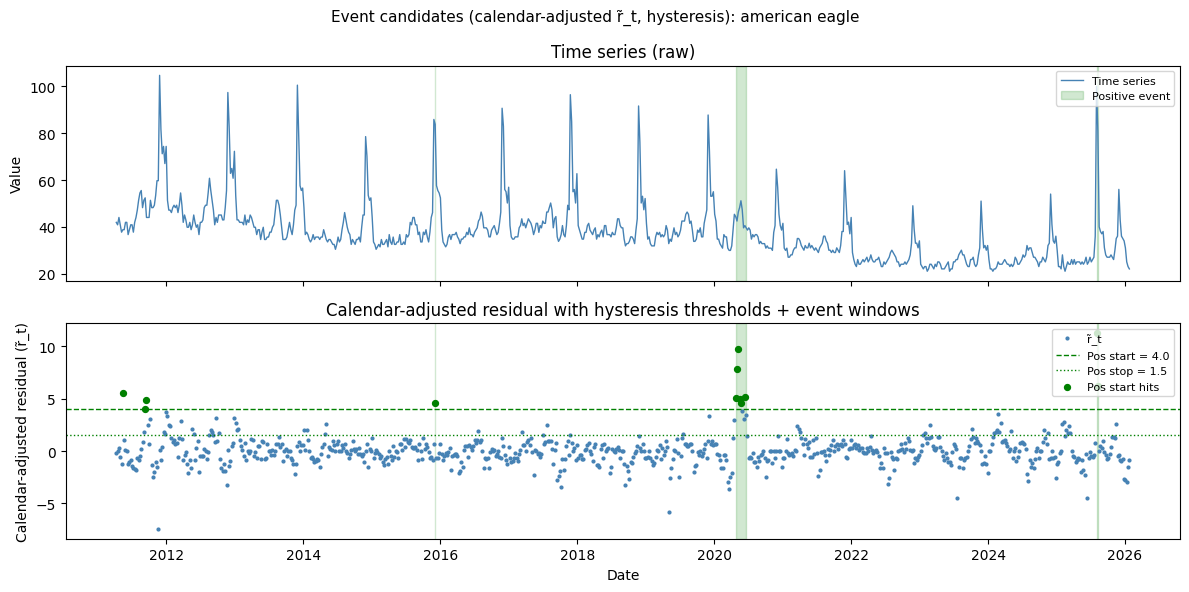

In [5]:
SAMPLE_KEYWORD = "american eagle"
PERIOD = 53
SEASONAL = 53
TREND = 103
EVENT_THRESHOLD_HIGH = 4.0
EVENT_STOP_POS = 1.5
START_CONSEC = 1
END_CONSEC = 2

REQUIRE_MIN_CHANGE = True
MIN_CHANGE_FRACTION = 0.2
PRE_WEEKS_FOR_AVG = 2

# Load timeseries from data
data_dir = Path(".") / "data"

#Gets all the timeseries files as they are separate. Separated due to scraping management.
ts_files = sorted(data_dir.glob("normalized_timeseries_branded_*_part*.csv"))
df_all = pd.concat([pd.read_csv(f) for f in ts_files], ignore_index=True)
ts_df = df_all.loc[df_all["keyword"] == SAMPLE_KEYWORD, ["date", "value"]].copy()
if ts_df.empty:
    raise ValueError(f"Keyword '{SAMPLE_KEYWORD}' not found in timeseries.")
ts_df["date"] = pd.to_datetime(ts_df["date"], utc=True)
ts = ts_df.sort_values("date").set_index("date").squeeze()
ts = ts.astype(float).resample("W-SAT").mean().ffill().bfill()
ts.index.freq = "W-SAT"

# STL decomposition (for trend, seasonal, residual subplots)
stl = STL(ts, seasonal=SEASONAL, trend=TREND, period=PERIOD)
res = stl.fit()
# Standardized residual and calendar-adjusted residual (same as pipeline)
stl_out = stl_decomposition(ts, period=PERIOD, seasonal=SEASONAL, trend=TREND)
r_t = stl_out["r_t"]
r_cal_t = stl_out["r_cal_t"]

# --- Figure 1: STL decomposition (non-standardized + standardized residual) ---
fig1, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig1.suptitle(f"STL decomposition: {SAMPLE_KEYWORD}", fontsize=14)
axes[0].plot(res.trend)
axes[0].set_ylabel("Trend")
axes[0].set_title("Trend")
axes[1].plot(res.seasonal)
axes[1].set_ylabel("Seasonal")
axes[1].set_title("Seasonal")
axes[2].plot(res.resid, marker="o", linestyle="none", markersize=2)
axes[2].set_ylabel("Residual")
axes[2].set_title("Residual (non-standardized)")
axes[3].plot(r_t, marker="o", linestyle="none", markersize=2)
axes[3].set_ylabel("Standardized residual (r_t)")
axes[3].set_xlabel("Date")
axes[3].set_title("Standardized residual (robust z-score)")
plt.tight_layout()
plt.show()

upper_windows = detect_events(
    r_cal_t,
    event_threshold_high=EVENT_THRESHOLD_HIGH,
    event_stop_pos=EVENT_STOP_POS,
    start_consec=START_CONSEC,
    end_consec=END_CONSEC,
) 

# This is the new min_change functionality.
# Idea is that event creation w/ only residual extraction might include non-relevant out of the ordinary changes in the time series
# We are only interested in spikes that have 
if REQUIRE_MIN_CHANGE:
    filtered = []
    for t_s, t_e in upper_windows:
        pre_slice = ts.loc[(ts.index >= t_s - pd.DateOffset(weeks=PRE_WEEKS_FOR_AVG)) & (ts.index < t_s)]
        pre_avg = pre_slice.mean()
        ev_slice = ts.loc[t_s:t_e]
        if len(ev_slice) == 0:
            continue
        denom = max(abs(pre_avg), 1e-9) if pd.notna(pre_avg) else 1e-9
        rel_changes = (ev_slice - pre_avg).abs() / denom
        if (rel_changes >= MIN_CHANGE_FRACTION).any():
            filtered.append((t_s, t_e))
    upper_windows = filtered
upper_points = r_cal_t >= EVENT_THRESHOLD_HIGH

# --- Figure 2: Event window plot (raw series + r_cal_t with thresholds and windows) ---
fig2, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig2.suptitle(f"Event candidates (calendar-adjusted r̃_t, hysteresis): {SAMPLE_KEYWORD}", fontsize=11)
axes[0].plot(ts.index, ts.values, color="steelblue", linewidth=1, label="Time series")
first_pos = True
for a, b in upper_windows:
    axes[0].axvspan(a, b, alpha=0.18, color="green", label="Positive event" if first_pos else None)
    first_pos = False
axes[0].set_ylabel("Value")
axes[0].set_title("Time series (raw)")
axes[0].legend(loc="upper right", fontsize=8)
axes[1].plot(r_cal_t.index, r_cal_t.values, marker="o", linestyle="none", markersize=2, color="steelblue", label="r̃_t")
for a, b in upper_windows:
    axes[1].axvspan(a, b, alpha=0.18, color="green")
axes[1].axhline(EVENT_THRESHOLD_HIGH, color="green", linestyle="--", linewidth=1, label=f"Pos start = {EVENT_THRESHOLD_HIGH}")
axes[1].axhline(EVENT_STOP_POS, color="green", linestyle=":", linewidth=1, label=f"Pos stop = {EVENT_STOP_POS}")
if upper_points.any():
    axes[1].scatter(r_cal_t[upper_points].index, r_cal_t[upper_points].values, color="green", s=18, zorder=5, label="Pos start hits")
axes[1].set_ylabel("Calendar-adjusted residual (r̃_t)")
axes[1].set_xlabel("Date")
axes[1].set_title("Calendar-adjusted residual with hysteresis thresholds + event windows")
axes[1].legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

## 2.2 Event window creation for all keywords and matching them to company fisical quarters 

Note: Can take up to 10 minutes to finish

On Ryzen 5 5600x (has 6-cores) takes 3.5 minutes. 

In [6]:
# Load all-quarters for CDF comparison F_keyword(x) - F_all(x)
data_path = Path(".") / "data" / "earnings_data.csv"
earnings = pd.read_csv(data_path)
earnings["surprisePercent"] = pd.to_numeric(earnings["surprisePercent"], errors="coerce")
earnings = earnings.dropna(subset=["surprisePercent"])

TEST_MODE = False


param_configs = [
    {
        "name": "ev_thresh_2_min_change_0.2",
        "event_threshold_high": 2.0,
        "event_stop_pos": 1.5,
        "start_consec": 1,
        "end_consec": 2,
        "min_change_fraction": 0.2,
        "require_min_change": True,
    },
    {
        "name": "ev_thresh_3_min_change_0.2",
        "event_threshold_high": 3.0,
        "event_stop_pos": 1.5,
        "start_consec": 1,
        "end_consec": 2,
        "min_change_fraction": 0.2,
        "require_min_change": True,

    },
    {
        "name": "ev_thresh_4_min_change_0.2",
        "event_threshold_high": 4.0,
        "event_stop_pos": 1.5,
        "start_consec": 1,
        "end_consec": 2,
        "min_change_fraction": 0.2,
        "require_min_change": True,
    },
]

pipeline_results = {}

if TEST_MODE:
    print("TEST MODE: Processing only first {} keywords".format(TEST_KEYWORD_LIMIT))

for config in param_configs:
    print(f"\n{'='*60}")
    print(f"Running pipeline with config: {config['name']}")
    print(f"{'='*60}")
    
    try:
        events_df, quarter_events_df = run_full_pipeline(
            event_threshold_high=config["event_threshold_high"],
            event_stop_pos=config["event_stop_pos"],
            start_consec=config["start_consec"],
            end_consec=config["end_consec"],
            save_events=False, 
            save_quarter_events=False,  
            verbose=True, 
            test_keyword_limit=TEST_KEYWORD_LIMIT if TEST_MODE else None,  
            n_jobs=None,    
            require_min_change=config["require_min_change"],
            min_change_fraction=config["min_change_fraction"]
        )
        
    
        quarter_events_df["surprisePercent"] = pd.to_numeric(quarter_events_df["surprisePercent"], errors="coerce")
        quarter_events_df = quarter_events_df.dropna(subset=["surprisePercent"])
        
        pipeline_results[config["name"]] = {
            "events_df": events_df,
            "quarter_events_df": quarter_events_df,
            "config": config
        }
        
        print(f"\n  Config {config['name']}: {len(quarter_events_df)} quarter events")
        print(f"  Unique (company, quarter): {quarter_events_df[['company','quarter_end']].drop_duplicates().shape[0]}")
        
    except Exception as e:
        print(f"\n ERROR in config {config['name']}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Use default configuration for subsequent analysis
if "default" in pipeline_results:
    df = pipeline_results["default"]["quarter_events_df"].copy()
    print(f"\n Using 'default' configuration for analysis: {len(df)} rows")
else:
    print("\n  WARNING: No 'default' configuration results available!")
    print("Available configurations:", list(pipeline_results.keys()))



Running pipeline with config: ev_thresh_2_min_change_0.2
[PIPELINE] Starting full pipeline at 2026-02-22 11:54:35
[PIPELINE] Parameters:
  event_threshold_high: 2.0
  event_stop_pos: 1.5
  start_consec: 1
  end_consec: 2
  period: 53, seasonal: 53, trend: 103
  require_min_change: True, min_change_fraction: 0.2, pre_weeks_for_avg: 4
[PIPELINE] Step 1/3: Loading time series data from data
[PIPELINE] Found 31 time series files
[PIPELINE] Loaded 2185194 rows in 0.93 seconds
[PIPELINE] Unique keywords: 2884

[PIPELINE] Step 2/3: Building event table
[BUILD_EVENT_TABLE] Starting at 11:54:36
[BUILD_EVENT_TABLE] Input: 2185194 rows, 2884 unique keywords
[BUILD_EVENT_TABLE] Filtering keywords by min_nonzero_frac >= 0.9
[BUILD_EVENT_TABLE] After filtering: 1854 keywords to process
[BUILD_EVENT_TABLE] Using 12 parallel workers
[BUILD_EVENT_TABLE] Processing in parallel with 12 workers...
[BUILD_EVENT_TABLE] Progress: 10/1854 keywords (0.5%), 129 events found, ETA: 15.0 min
[BUILD_EVENT_TABLE] P

In [7]:
# Preprocessing for all distributions: exclude first 1 years of quarters/events (e.g. 2011 -> use from 2012 onward)
_default_q = pipeline_results.get("default", {}).get("quarter_events_df")
if _default_q is not None and len(_default_q) > 0:
    qe = pd.to_datetime(_default_q["quarter_end"], utc=True)
    _min_date = qe.min()
    _cutoff = _min_date + pd.DateOffset(years=1)
    for config_name, results in pipeline_results.items():
        qdf = results["quarter_events_df"]
        qdf = qdf.loc[pd.to_datetime(qdf["quarter_end"], utc=True) >= _cutoff].copy()
        results["quarter_events_df"] = qdf
        ev_df = results["events_df"]
        ev_df = ev_df.loc[pd.to_datetime(ev_df["t_start"], utc=True) >= _cutoff].copy()
        results["events_df"] = ev_df
    print(f"Excluded first 2 years: using quarters/events from {_cutoff.date()} onward.")

# Refresh default df if used
if "default" in pipeline_results:
    df = pipeline_results["default"]["quarter_events_df"].copy()

# 3. Results

## 3.1 Comparing distributions

The below plot shows the epsSurprise of quarters that have had a spike in at least one of the keywords associated with the company within the timespan of the quarter.  

e_v_threshold is a detection threshold for how abnormal the postive spike in keyword traffic is.

ev_thresh_2_min_change_0.2: E[X] = 5.2938%, Var(X) = 7616.5814, n = 5764, P(EPS>0) = 0.5852, ΔP(EPS>0) = 0.0120
  KS vs earnings_all: statistic = 0.0123, p-value = 0.5666; at α=0.05: Fail to reject H0
ev_thresh_3_min_change_0.2: E[X] = 5.2418%, Var(X) = 7973.5888, n = 4204, P(EPS>0) = 0.5830, ΔP(EPS>0) = 0.0098
  KS vs earnings_all: statistic = 0.0112, p-value = 0.8061; at α=0.05: Fail to reject H0
ev_thresh_4_min_change_0.2: E[X] = 6.3718%, Var(X) = 8007.8628, n = 3087, P(EPS>0) = 0.5938, ΔP(EPS>0) = 0.0206
  KS vs earnings_all: statistic = 0.0214, p-value = 0.1973; at α=0.05: Fail to reject H0


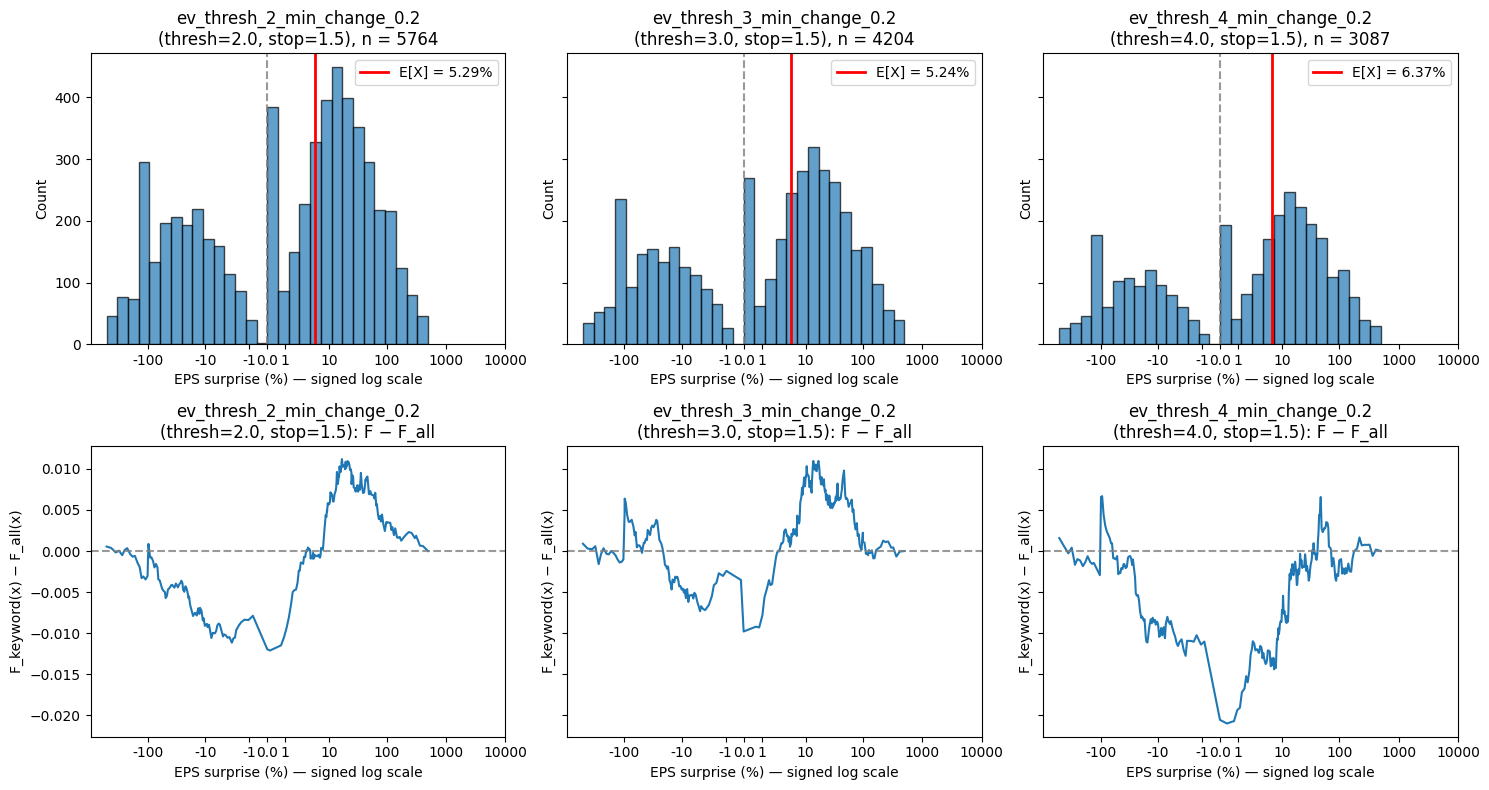

In [8]:
## Compare results across different parameter configurations
n_configs = len(pipeline_results)
fig, axes = plt.subplots(2, n_configs, figsize=(5 * n_configs, 8), sharey="row")
if n_configs == 1:
    axes = axes[:, np.newaxis]

# Reference distribution (earnings_all)
y_all_filtered = y_all[(y_all >= -OUTLIER_THRESHOLD) & (y_all <= OUTLIER_THRESHOLD)]
n_bins = 10
bin_edges = np.percentile(y_all_filtered, np.linspace(0, 100, n_bins + 1))
bin_edges = np.unique(bin_edges)  # avoid duplicate edges
if len(bin_edges) < 2:
    bin_edges = np.linspace(y_all_filtered.min(), y_all_filtered.max(), n_bins + 1)
alpha = 0.05

for idx, (config_name, results) in enumerate(pipeline_results.items()):
    config_df = results["quarter_events_df"]
    one_per_quarter = config_df.drop_duplicates(subset=["company", "quarter_end"])

    y = one_per_quarter["surprisePercent"]

    # Filter outliers again w/ copypaste
    y = y[(y >= -OUTLIER_THRESHOLD) & (y <= OUTLIER_THRESHOLD)]
    y_log = signed_log1p(y)

    config = results["config"]
    title = f"{config_name}\n(thresh={config['event_threshold_high']}, stop={config['event_stop_pos']})"

    # Histogram
    ax_hist = axes[0, idx]
    ax_hist.hist(y_log, bins=30, edgecolor="black", alpha=0.7)
    ax_hist.axvline(0, color="gray", linestyle="--", alpha=0.8)
    mean_y = float(y.mean())
    ax_hist.axvline(signed_log1p(mean_y), color="red", linewidth=2, label=f"E[X] = {mean_y:.2f}%")
    ax_hist.set_xlabel("EPS surprise (%) — signed log scale")
    ax_hist.set_ylabel("Count")
    ax_hist.set_title(f"{title}, n = {len(y)}")
    ax_hist.legend()
    tick_vals = np.array([-100, -10, -1, 0, 1, 10, 100, 1000, 1e4])
    ax_hist.set_xticks(signed_log1p(tick_vals))
    ax_hist.set_xticklabels([f"{t:.0f}" if abs(t) >= 1 else f"{t:.1f}" for t in tick_vals])

    # CDF difference
    ax_cdf = axes[1, idx]
    plot_cdf_diff(y, y_all, ax_cdf, f"{title}: F − F_all")

    # Compute P(EPS>0) and ΔP(EPS>0)
    p_eps_positive_cond = float((y > 0).mean())
    delta_p_eps_positive = p_eps_positive_cond - p_eps_positive_all

    # Kolmogorov-Smirnov test vs earnings_all at 5% level
    ks_stat, ks_pvalue = ks_2samp(np.asarray(y), np.asarray(y_all))
    ks_reject = ks_pvalue < alpha

    print(f"{config_name}: E[X] = {mean_y:.4f}%, Var(X) = {float(y.var()):.4f}, n = {len(y)}, P(EPS>0) = {p_eps_positive_cond:.4f}, ΔP(EPS>0) = {delta_p_eps_positive:.4f}")
    print(f"  KS vs earnings_all: statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}; at α={alpha}: {'Reject H0' if ks_reject else 'Fail to reject H0'}")

plt.tight_layout()
plt.show()


In [10]:
# Columns
pipeline_results["ev_thresh_4_min_change_0.2"]["quarter_events_df"].columns

Index(['t_start', 't_peak', 't_end', 'peak_z_e', 'area_z_e', 'duration_e',
       'seasonal_surprise_e', 'half_life_e', 'rise_slope_e', 'decay_slope_e',
       'asymmetry_e', 'baseline_shift_z_e', 'retention_ratio_e',
       'regime_shift_flag_e', 'keyword', 'company', 'company_norm',
       'quarter_start', 'quarter_end', 'reportDate', 'ticker', 'exchange',
       'epsActual', 'epsEstimate', 'epsDifference', 'surprisePercent',
       'currency'],
      dtype='object')

## 3.2 Distribution of EPS surprise given event conditions 

Keyword features used in the following section:

1. area_z_e: Calculated as the maximum standardized residual during the event window



```math
\text{peak\_z\_e} = \max_{t \in [t_s, t_e]} ev(t)
```

2. peak_z_e: The sum of (positive) event-window values inside the event.  


```math
\text{area\_z\_e} = \sum_{t \in [t_s, t_e]} \max\big(ev(t), 0\big)
```

3. baseline_shift_z_e: The change in the adjusted residual after the event compared to before the event. To measure if traffic impacts the trend component in the short-term.

The median of the window of time from t_s pre weeks up to t_s

```math
\text{pre\_level} =
\operatorname{median}
\left\{
r_t \;:\;
t \in [t_s - \Delta_{\text{pre}},\, t_s)
\right\}
```
The median of the window of time from t_e up to post amount of weeks.
```math
\text{post\_level} =
\operatorname{median}
\left\{
r_t \;:\;
t \in (t_e,\, t_e + \Delta_{\text{post}}]
\right\}
```

```math
\text{baseline\_shift\_z\_e}
=
\text{post\_level}
-
\text{pre\_level}
```

area_z_e > 3.0:   E[X] = 6.2133%   Var(X) = 8151.9038   P(EPS>0) = 0.5919   ΔP(EPS>0) = 0.0187
  KS test vs earnings_all: statistic = 0.0195, p-value = 0.3177; at α=0.05: Fail to reject H0 (no evidence distributions differ)
area_z_e > 5:   E[X] = 7.5935%   Var(X) = 8035.3963   P(EPS>0) = 0.5949   ΔP(EPS>0) = 0.0217
  KS test vs earnings_all: statistic = 0.0223, p-value = 0.2424; at α=0.05: Fail to reject H0 (no evidence distributions differ)
area_z_e > 8.0:   E[X] = 7.8248%   Var(X) = 7836.4482   P(EPS>0) = 0.5946   ΔP(EPS>0) = 0.0214
  KS test vs earnings_all: statistic = 0.0242, p-value = 0.2547; at α=0.05: Fail to reject H0 (no evidence distributions differ)


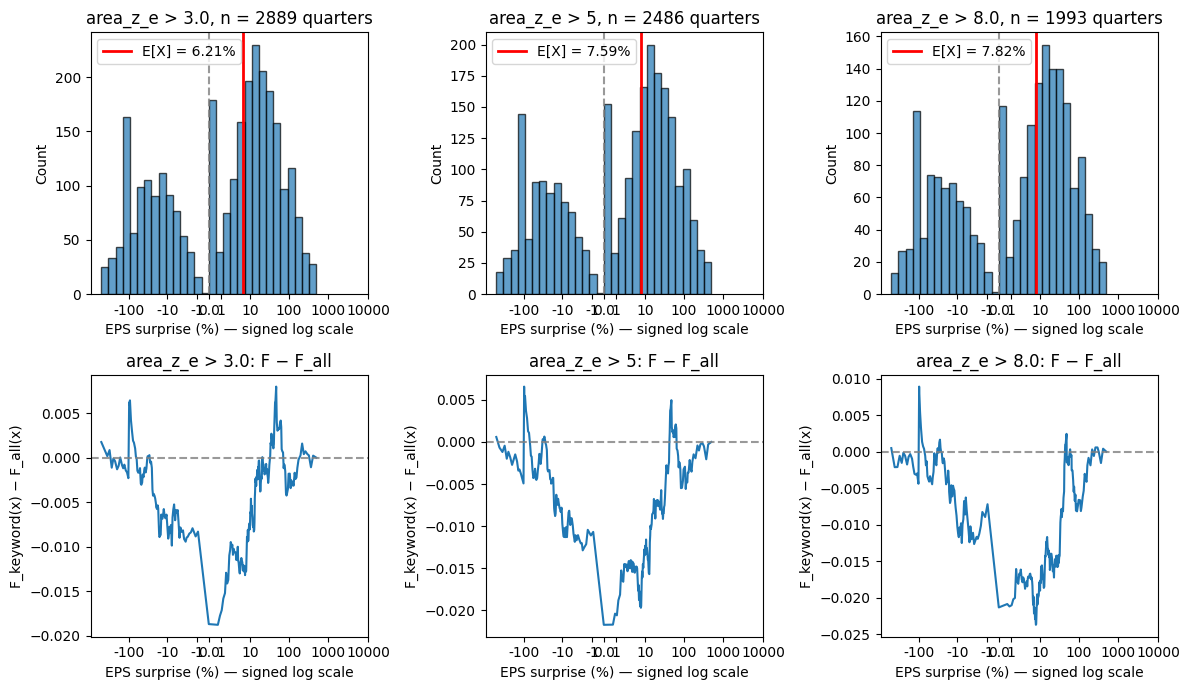

peak_z_e > 3.0:   E[X] = 5.7964%   Var(X) = 8297.1284   P(EPS>0) = 0.5893   ΔP(EPS>0) = 0.0161
  KS test vs earnings_all: statistic = 0.0167, p-value = 0.5471; at α=0.05: Fail to reject H0 (no evidence distributions differ)
peak_z_e > 5:   E[X] = 6.0554%   Var(X) = 7567.4472   P(EPS>0) = 0.5887   ΔP(EPS>0) = 0.0155
  KS test vs earnings_all: statistic = 0.0160, p-value = 0.7822; at α=0.05: Fail to reject H0 (no evidence distributions differ)
peak_z_e > 8.0:   E[X] = 4.8627%   Var(X) = 6529.4160   P(EPS>0) = 0.6038   ΔP(EPS>0) = 0.0305
  KS test vs earnings_all: statistic = 0.0313, p-value = 0.2849; at α=0.05: Fail to reject H0 (no evidence distributions differ)


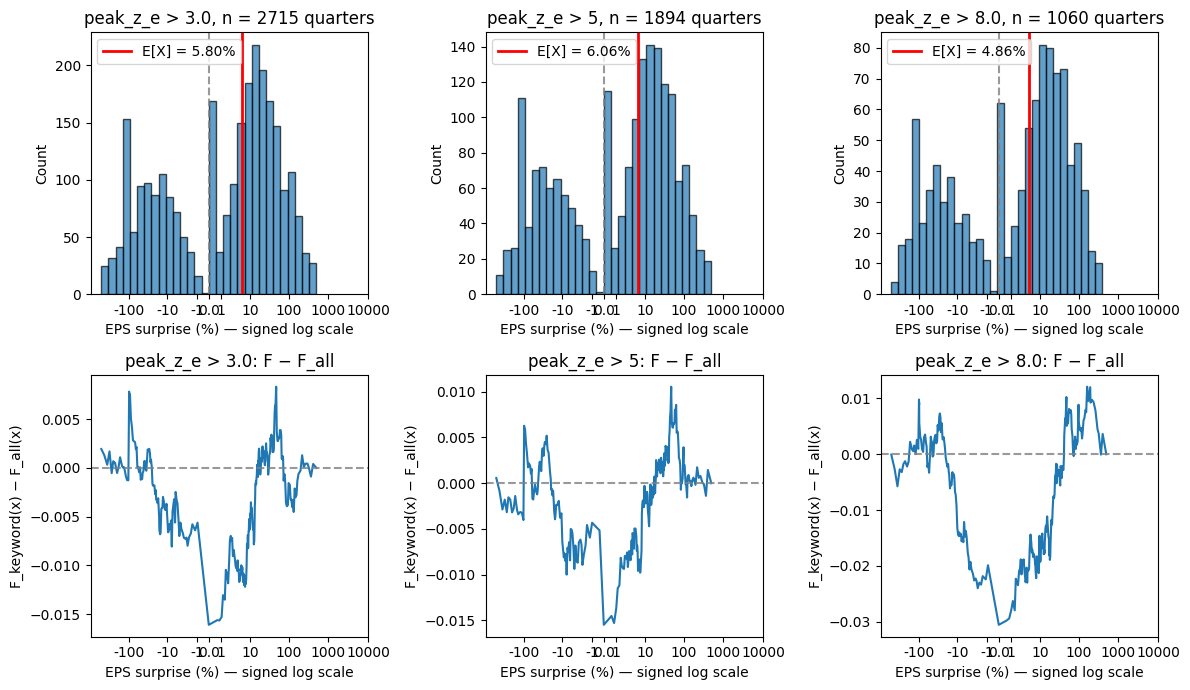

baseline_shift_z_e > 0.01:   E[X] = 9.0879%   Var(X) = 7752.5577   P(EPS>0) = 0.6103   ΔP(EPS>0) = 0.0371
  KS test vs earnings_all: statistic = 0.0378, p-value = 0.0169; at α=0.05: Reject H0 (distributions differ)
baseline_shift_z_e > 0.05:   E[X] = 9.2243%   Var(X) = 7818.7531   P(EPS>0) = 0.6132   ΔP(EPS>0) = 0.0399
  KS test vs earnings_all: statistic = 0.0406, p-value = 0.0093; at α=0.05: Reject H0 (distributions differ)
baseline_shift_z_e > 1.5:   E[X] = 11.1470%   Var(X) = 7574.4600   P(EPS>0) = 0.6320   ΔP(EPS>0) = 0.0587
  KS test vs earnings_all: statistic = 0.0625, p-value = 0.0337; at α=0.05: Reject H0 (distributions differ)


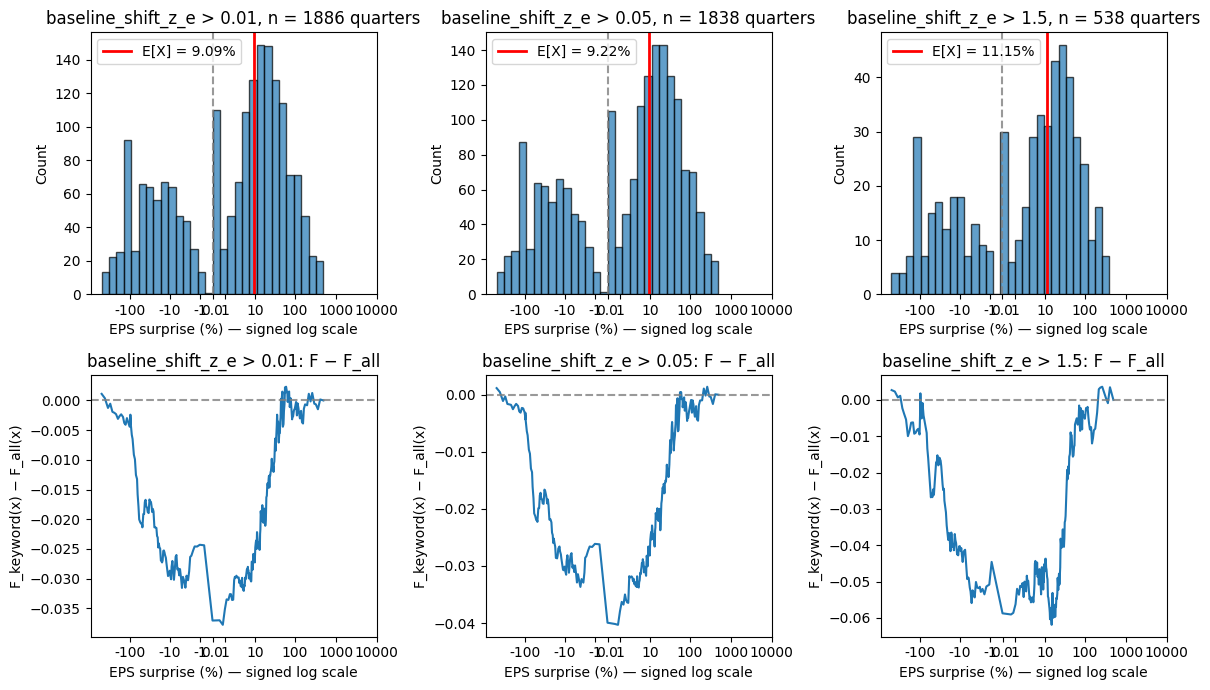

In [11]:
threshold_to_measure = "ev_thresh_4_min_change_0.2"

df = pipeline_results[threshold_to_measure]["quarter_events_df"].copy()

for col in ["area_z_e",]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

features = [ ("area_z_e", 3.0),  ("area_z_e", 5), ("area_z_e", 8.0)]
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
for i, (feature_col, threshold) in enumerate(features):
    plot_feature_hist_and_cdf_diff(df, feature_col, threshold, y_all, 
                                    axes[0, i], axes[1, i], None)
plt.tight_layout()
plt.show()

for col in ["peak_z_e",]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

features = [ ("peak_z_e", 3.0),  ("peak_z_e", 5), ("peak_z_e", 8.0)]
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
for i, (feature_col, threshold) in enumerate(features):
    plot_feature_hist_and_cdf_diff(df, feature_col, threshold, y_all, 
                                    axes[0, i], axes[1, i], None)
plt.tight_layout()
plt.show()


for col in ["baseline_shift_z_e",]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Seems to be important
features = [ ("baseline_shift_z_e", 0.01),  ("baseline_shift_z_e", 0.05), ("baseline_shift_z_e", 1.5)]
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
for i, (feature_col, threshold) in enumerate(features):
    plot_feature_hist_and_cdf_diff(df, feature_col, threshold, y_all, 
                                    axes[0, i], axes[1, i], None)

plt.tight_layout()
plt.show()


## 3.3 Analysis of the conditional distributions

Only the conditional distribution (baseline_shift_z_e > 0.05 & e_threshold_4) has a high enough test statistic value D_n to reject the null hypothesis.

What to infer about the distribution:




baseline_shift_z_e > 0.05 (ev_thresh_4), n = 1838: ΔP(EPS < 0) = -0.0268
baseline_shift_z_e > 0.05 (ev_thresh_4): ΔP(EPS > Q75_all) = 0.0150  


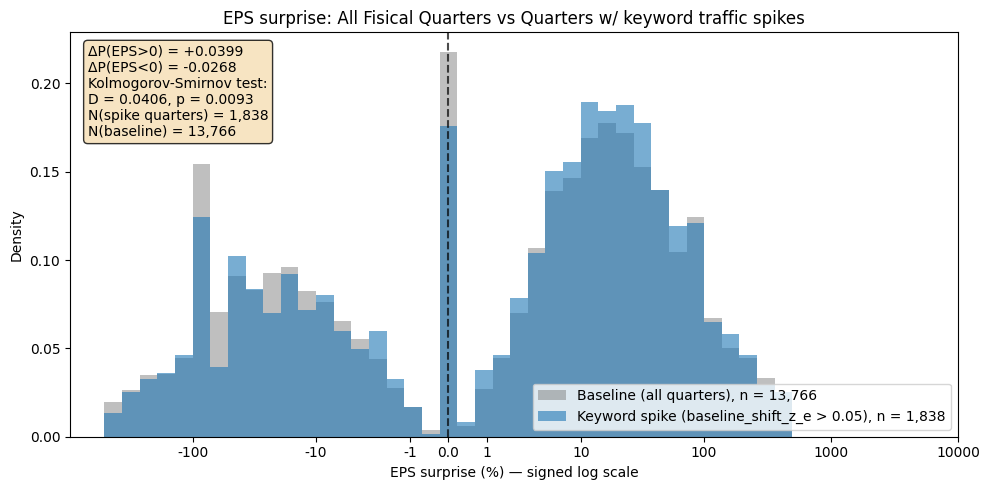

In [12]:
mask_05 = (df["baseline_shift_z_e"] > 0.05)
sub_05 = df.loc[mask_05].drop_duplicates(subset=["company", "quarter_end"])
y_05 = sub_05["surprisePercent"]

# Outlier removal copy-paste
y_05 = y_05[(y_05 >= -OUTLIER_THRESHOLD) & (y_05 <= OUTLIER_THRESHOLD)]
y_all_f = y_all[(y_all >= -OUTLIER_THRESHOLD) & (y_all <= OUTLIER_THRESHOLD)]


p_cond_lt0 = (y_05 < 0).mean()
p_all_lt0 = (y_all_f < 0).mean()
delta_p_lt0 = p_cond_lt0 - p_all_lt0
Q75_all = np.percentile(y_all_f, 75)

p_cond_gt75 = (y_05 > Q75_all).mean()
p_all_gt75 = (y_all_f > Q75_all).mean()
delta_p_gt75 = p_cond_gt75 - p_all_gt75

print(f"baseline_shift_z_e > 0.05 (ev_thresh_4), n = {len(y_05)}: ΔP(EPS < 0) = {delta_p_lt0:.4f}")
print(f"baseline_shift_z_e > 0.05 (ev_thresh_4): ΔP(EPS > Q75_all) = {delta_p_gt75:.4f}  ")


# Dual histogram
fig, ax = plt.subplots(figsize=(10, 5))
y_all_log = signed_log1p(y_all_f)
y_05_log = signed_log1p(y_05)
bins = np.linspace(min(y_all_log.min(), y_05_log.min()), max(y_all_log.max(), y_05_log.max()), 40)

ax.hist(y_all_log, bins=bins, alpha=0.5, color="gray", label=f"Baseline (all quarters), n = {len(y_all_f):,}", density=True)
ax.hist(y_05_log, bins=bins, alpha=0.6, color="C0", label=f"Keyword spike (baseline_shift_z_e > 0.05), n = {len(y_05):,}", density=True)
ax.axvline(0, color="black", linestyle="--", alpha=0.7)
ax.set_xlabel("EPS surprise (%) — signed log scale")
ax.set_ylabel("Density")
ax.set_title("EPS surprise: All Fisical Quarters vs Quarters w/ keyword traffic spikes")
tick_vals = np.array([-100, -10, -1, 0, 1, 10, 100, 1000, 1e4])
ax.set_xticks(signed_log1p(tick_vals))
ax.set_xticklabels([f"{t:.0f}" if abs(t) >= 1 else f"{t:.1f}" for t in tick_vals])
ax.legend(loc="lower right")

p_cond_gt0 = (y_05 > 0).mean()

p_all_gt0 = (y_all_f > 0).mean()
delta_p_gt0 = p_cond_gt0 - p_all_gt0

ks_stat, ks_pvalue = ks_2samp(np.asarray(y_05), np.asarray(y_all_f))

textstr = "\n".join([
    f"ΔP(EPS>0) = {delta_p_gt0:+.4f}",
    f"ΔP(EPS<0) = {delta_p_lt0:+.4f}",
    f"Kolmogorov-Smirnov test:",
    f"D = {ks_stat:.4f}, p = {ks_pvalue:.4f}",
    f"N(spike quarters) = {len(y_05):,}",
    f"N(baseline) = {len(y_all_f):,}",
])
props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
ax.text(0.02, 0.97, textstr, transform=ax.transAxes, fontsize=10, verticalalignment="top", bbox=props)
plt.tight_layout()
plt.show()


We can see that ΔP(EPS < 0 ) is negative and ΔP(EPS > Q_75_all) is positive.

This means that earnings quarters with higher 'relative popularity' spikes have less negative earnings surprises and more higher earnings surprises. The difference in the distributions is enough to see visually in the above histogram.